# Part 8 -- KMeans Clustering

Prepare data for **Singular Value Decomposition (SVD)**.

### Load lib codes:

In [2]:
!pwd

/home/jovyan/work/Portfolio/predicting_stock_market_trends_with_Twitter/ipynb


In [3]:
from os import chdir
chdir('/home/jovyan/work/Portfolio/predicting_stock_market_trends_with_Twitter/')

from lib import *
from lib.twitter_keys import my_keys
suppress_warnings()
%matplotlib inline
from sklearn.externals import joblib

In [57]:
TSNE_SVD_tfidf_10000 = joblib.load('../predicting_stock_market_trends_with_Twitter/data/TSNE_SVD_tfidf_10000.pickle')

In [5]:
from sklearn.cluster import KMeans, MiniBatchKMeans

# TNSE

In [89]:
# Try with TSNE_SVD_tfidf_10000:
km = KMeans(n_clusters=10, random_state=42)
km.fit(TSNE_SVD_tfidf_10000)
km_clusters = km.predict(TSNE_SVD_tfidf_10000)
km_distances = km.transform(TSNE_SVD_tfidf_10000)

In [90]:
kmeans_model = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, random_state=42)
kmeans = kmeans_model.fit(TSNE_SVD_tfidf_10000)
kmeans_clusters = kmeans.predict(TSNE_SVD_tfidf_10000)
kmeans_distances = kmeans.transform(TSNE_SVD_tfidf_10000)

Mini Batch K-means ([11]) has been proposed as an alternative to the K-means algorithm for clustering massive
datasets. The advantage of this algorithm is to reduce the computational cost by not using all the dataset
each iteration but a subsample of a fixed size. This strategy reduces the number of distance computations per
iteration at the cost of lower cluster quality.

Now let's try and visualize the tweets again, according to their distance from each centroid in our K clusters. We are going to use t-SNE again to reduce the dimensionality from 10 (we had 10 clusters/centroids) down to 2.

In [91]:
tsne_kmeans = kmeans_model.fit_transform(kmeans_distances[:10000])

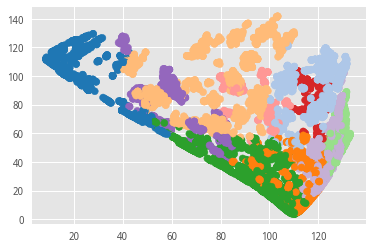

In [92]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plt.scatter(tsne_kmeans[:,0], tsne_kmeans[:,1], c=colormap[kmeans_clusters][:10000])

The separation seems to have improved, but there are some overlaps between different clusters, and the islands are still formed around keywords and keyphrases.

In [34]:
!pip install lda

    100% |████████████████████████████████| 501kB 2.1MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 5.9MB/s ta 0:00:01
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Latent Dirichlet Allocation (LDA)
Next we're going to use a well-known topic modeling algorithm called LDA, to uncover the latent topics in the tweets, and then wet're going to use the topic distributions for each document as a measure to group similar tweets together.
First we vectorize our data by representing each tweet as a 10k dimensional vector whose indices correspond to the 10k most frequent terms in our corpus. We then feed this 77,000 x 10,000 feature matrix into LDA to detect the latent topics in our data. While there are non-parametric alternatives available, the classic version of LDA allows us to specify the number of topics that we want to discover upfront. We run LDA for 2,000 iterations to identify 15 topics and receive a 77k x 15 matrix of topic distributions of our tweets.

In [38]:
X = joblib.load('../predicting_stock_market_trends_with_Twitter/data/X.pickle')

In [42]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

In [98]:
cleaned_text = list(X['cleaned_text'])

In [99]:
type(cleaned_text)

list

In [100]:
# start = datetime.now()

# cvectorizer = CountVectorizer(min_df=4, max_features=10000, stop_words='english')
# cvz = cvectorizer.fit_transform(cleaned_text)

# n_topics = 15
# n_iter = 2000
# lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
# X_topics = lda_model.fit_transform(cvz)

# end = datetime.now()
# print(end - start)

INFO:lda:n_documents: 68006
INFO:lda:vocab_size: 10000
INFO:lda:n_words: 492052
INFO:lda:n_topics: 15
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -6243423
INFO:lda:<10> log likelihood: -4653469
INFO:lda:<20> log likelihood: -4452913
INFO:lda:<30> log likelihood: -4364717
INFO:lda:<40> log likelihood: -4314963
INFO:lda:<50> log likelihood: -4287931
INFO:lda:<60> log likelihood: -4266257
INFO:lda:<70> log likelihood: -4252125
INFO:lda:<80> log likelihood: -4240606
INFO:lda:<90> log likelihood: -4233116
INFO:lda:<100> log likelihood: -4227325
INFO:lda:<110> log likelihood: -4221498
INFO:lda:<120> log likelihood: -4217856
INFO:lda:<130> log likelihood: -4211888
INFO:lda:<140> log likelihood: -4209623
INFO:lda:<150> log likelihood: -4205168
INFO:lda:<160> log likelihood: -4203599
INFO:lda:<170> log likelihood: -4198900
INFO:lda:<180> log likelihood: -4198140
INFO:lda:<190> log likelihood: -4195676
INFO:lda:<200> log likelihood: -4193403
INFO:lda:<210> log likelihood: -4193301
INFO:ld

INFO:lda:<1990> log likelihood: -4160319
INFO:lda:<1999> log likelihood: -4160164


0:03:47.483541


Let us now look at those topics in more detail. Specifically, we can inspect the words that are most relevant to a topic. We save these words as topic summaries for later.

In [102]:
n_top_words = 8
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: new ceo tcdisrupt tech million company startup billion
Topic 1: money rt make things best people 10 buy
Topic 2: new google apple amazon iphone facebook microsoft app
Topic 3: rt tesla car new model uber just driving
Topic 4: trump rt cnnpolitics house president says russia white
Topic 5: rt today thank live great amp watch join
Topic 6: today nice price buy amp target short tgt
Topic 7: change climate actonclimate energy rt court senate world
Topic 8: says rt police attack people new say korea
Topic 9: like don people know just rt think good
Topic 10: trump rt hillary health donald care tax clinton
Topic 11: rt new best mark just game twitter watch
Topic 12: year market earnings amp stocks today stock time
Topic 13: president obama rt america hillary make american people
Topic 14: rt great world amp new work people help


In [62]:
# This was wrong...
# n_top_words = 8
# topic_summaries = []

# topic_word = lda_model.topic_word_  # get the topic words
# vocab = cvectorizer.get_feature_names()
# for i, topic_dist in enumerate(topic_word):
#     topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#     topic_summaries.append(' '.join(topic_words))
#     print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: rt year like trump watch live world ve
Topic 1: getting companies deal 500 trade record hit vote
Topic 2: valley silicon morning chance driving judge coming seen
Topic 3: better 100 app let game note add hours
Topic 4: new day hillary know work 000 love job
Topic 5: rt trump today president time make says don
Topic 6: just amp people obama good think week ceo
Topic 7: great future apple free wall 12 short run
Topic 8: 10 china business ahead fun 17 cost means
Topic 9: working coverage hear firing enjoy common sessions morgan
Topic 10: aapl message incredible facts reach ios tonight voters
Topic 11: tgt class key early fighting sources india design
Topic 12: launch finally living ft photos product including event
Topic 13: got congrats death going spy jack long names
Topic 14: rt trump meet national time global soon new


Most of these topics look somewhat coherent:
```
Topic 0/5: trump
Topic 1 trading
Topic 2: tech
Topic 3: ?
Topic 4/6: positive
Topic 7/8: positive future?
Topic 9: jobs/industry
Topic 10: news?
Topic 11: ?
Topic 12: tech
Topic 13: ?
Topic 14: news
```

To visualize the tweets according to their topic distributions, we first need to reduce the dimensionality from 15 down to 2 using t-SNE:

In [63]:
SVD_tfidf_10000 = joblib.load('../predicting_stock_market_trends_with_Twitter/data/SVD_tfidf_10000.pickle')

In [74]:
from sklearn.manifold import TSNE

# tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
# tsne_tfidf = tsne_model.fit_transform(SVD_tfidf_10000)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.027977
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.251914
[t-SNE] Error after 300 iterations: 1.251914


In [75]:
start = datetime.now()

tsne_model = TSNE(n_components=2, verbose=1, random_state=42)
tsne_tfidf = tsne_model.fit_transform(SVD_tfidf_10000)

end = datetime.now()
print(end - start)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.027977
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.253812
[t-SNE] Error after 350 iterations: 1.253812
0:03:47.739487


In [76]:
tsne_lda = tsne_model.fit_transform(X_topics[:10000])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Error after 75 iterations: 0.000000


Let's get the main topic for each tweet, which we'll use to colorize them later on:

In [79]:
doc_topic = lda_model.doc_topic_
lda_keys = []
for i, tweet in enumerate(X):
    lda_keys += [doc_topic[i].argmax()]

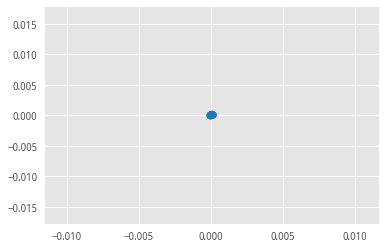

In [82]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plt.scatter(tsne_lda[:,0], tsne_lda[:,1], c=colormap[lda_keys][:10000])

This seems to be our best chart so far: there are entire islands dedicated to marketing or partying, without those words getting explicitly mentioned, so we've took a solid step towards a concept or topic-based representation.
Moreover, the chart not only puts similar tweets together, but also brings similar topics closer. Pay attention to how close business (grey) and marketing (dark pink) are, and how far innovation/future (orange) is pushed away from fun and partying (purple).